# Battle of neighborhoods

## Find the Best Neighborhoods/Boroughs for French restaurants 

**Introduction/Business Problem**  

This final project explores the best locations for French restaurants throughout the city of New York. New York is a major metropolitan area with more than 8.4 million (Quick Facts, 2018) people living within city limits. With many Manhattan inhabitants reporting French ancestry or appetite appreciation, the need to find and enjoy French cuisine is on the rise. This report explores which neighborhoods and boroughs of New York City have the most as well as the best French restaurants. Additionally, I will attempt to answer the questions “Where should I open a French Restaurant?” and “Where should I stay If I want great French food?”

**Data**  

Data
In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required. 

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset  

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm  

All data related to locations and quality of French restaurants will be obtained via the FourSquare API utilized via the Request library in Python.  

**Methodology**  

Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.  

FourSquare be used to locate all venues and then filtered by French restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.  

Data will be sorted based on rankings.  

Finally, the data be will be visually assessed using graphing from various Python libraries.

**Library setup**

In [4]:
import pandas as pd
import numpy as np
import requests

#from bs4 import BeautifulSoup
import os

#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py36h9880bd3_2         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         248 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  certifi                          2020.6.20-py36h9f0ad1d_0 --> 2020.6.20-py36h9880bd3_2



certifi-2020.6.20    | 151 KB    

Foursquare credentials

In [5]:
CLIENT_ID = 'BFVDB35QOLIHSYH4PTNPP0KNLQIAASHA3HF3C1DT2D2N4PL2' # your Foursquare ID
CLIENT_SECRET = 'NEJ3DZCSCZKHKJYKPP3SZZXKWBGZEHF3EK4XC1PK215RUVYU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Define getting data functions

In [6]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data


Get data

In [7]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
ny_data.shape

(306, 4)

**Exploratory Analysis**

Neighborhoods per borough

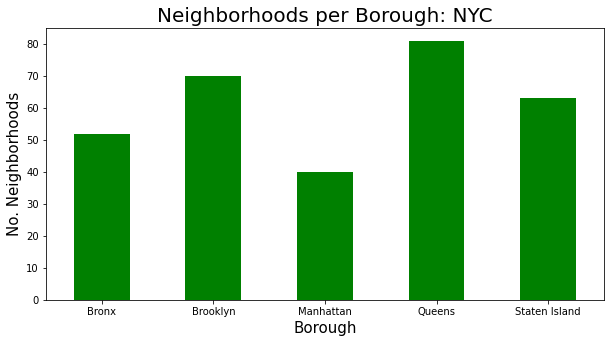

In [12]:
clr = "green"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize = (10,5), color = clr)

plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Prepare neighborhood list that contains French resturants

In [13]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
french_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    french_restaurants=venues[venues['Category']=='French Restaurant']   
    print('(',count,'/',len(ny_data),')','French Resturants in '+Neighborhood+', '+Borough+':'+str(len(french_restaurants)))
    print(row)
    for restaurant_detail in french_restaurants.values.tolist():
        id, name , category=restaurant_detail
        french_rest_ny = french_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) French Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) French Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) French Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) French Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) French Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) French Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) French Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) French Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) French Resturants in Norwood, Bronx:0
['Bronx', 'Norwood',

Save the french restaurants file

In [14]:
french_rest_ny.to_csv('/resources/labs/DS0701EN/french_rest_ny.csv')

In [15]:
french_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën
2,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin
3,Brooklyn,Windsor Terrace,4aee2d5cf964a520b7d221e3,Le P'tit Paris Bistro
4,Brooklyn,Bushwick,55e47d26498e44d12c7c004e,Le Garage


In [16]:
french_rest_ny.shape

(53, 4)

French restaurants per borough

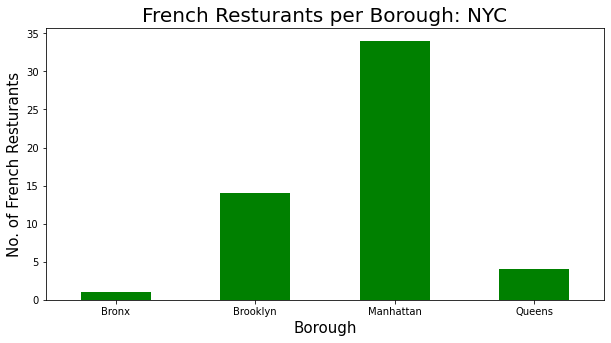

In [18]:
french_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('French Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of French Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

French restaurants per neighborhood

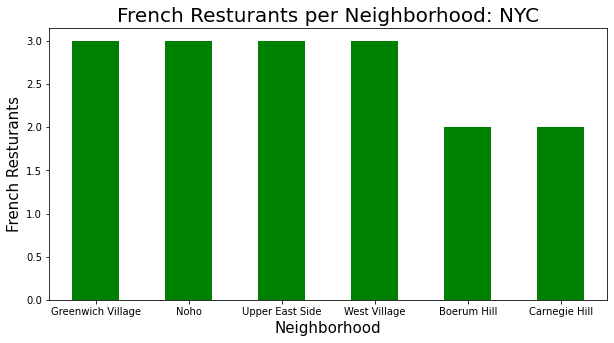

In [19]:
NOofNeigh = 6 # top number for graphing all the same past 6
french_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('French Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('French Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Pick out Greenwich Village, Noho, Upper East Side, and West Village

In [32]:
top_four = ['Greenwich Village', 'Noho', 'Upper East Side', 'West Village']
french_rest_ny[french_rest_ny.Neighborhood.isin(top_four)]

,Borough,Neighborhood,ID,Name
18,Manhattan,Upper East Side,3fd66200f964a5207fe91ee3,Café Boulud
19,Manhattan,Upper East Side,533b5715498ee1e90e846e1d,The Simone
20,Manhattan,Upper East Side,4408540af964a52055301fe3,Orsay
29,Manhattan,Greenwich Village,3fd66200f964a52006e61ee3,Raoul's Restaurant
30,Manhattan,Greenwich Village,50899082e4b0645d657eb40f,Cocotte
31,Manhattan,Greenwich Village,515f81d0e4b05d6decaaed19,Little Prince
36,Manhattan,West Village,4d0bf7e3f29c236ac675bfe7,Buvette
37,Manhattan,West Village,49958ac3f964a52084521fe3,Bobo
38,Manhattan,West Village,3fd66200f964a52006ea1ee3,Tartine
43,Manhattan,Noho,3fd66200f964a5202de51ee3,Lucien


Although Manhattan had the least number of neighborhoods, it does have the highest number of French restaurants. Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Greenwich Village, Noho, Upper East Side, and West Village have the highest number of French restaurants of 3 in all of NYC and all are located in the borough of Manhattan.

Prepare French restaurant stats

In [33]:
column_names=['Borough', 'Neighborhood', 'ID', 'Name', 'Likes', 'Rating', 'Tips']
french_rest_stats_ny=pd.DataFrame(columns = column_names)
count = 1

for row in french_rest_ny.values.tolist():
    Borough, Neighborhood, ID, Name = row
    try:
        venue_details = get_venue_details(ID)
        print(venue_details)
        id, name, likes, rating, tips = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id =',ID)
        
        # assign 0 value for these resturants as they may have been recently opened or details does not exist in FourSquare Database
        id, name, likes, rating, tips = [0] * 5
    print('(',count,'/',len(french_rest_ny),')', 'processed')
    french_rest_stats_ny = french_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index = True)
    count+=1
french_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5f8beb939d7cfa6c1b916c72'}, 'response': {'venue': {'id': '4d7aa83ee540f04d66ba16dc', 'name': 'Bistro SK', 'contact': {'phone': '7188851670', 'formattedPhone': '(718) 885-1670'}, 'location': {'address': '273 City Island Ave', 'lat': 40.84638676701103, 'lng': -73.78626182722242, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84638676701103, 'lng': -73.78626182722242}, {'label': 'entrance', 'lat': 40.846234, 'lng': -73.786269}], 'postalCode': '10464', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['273 City Island Ave', 'Bronx, NY 10464', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bistro-sk/4d7aa83ee540f04d66ba16dc', 'categories': [{'id': '4bf58dd8d48988d10c941735', 'name': 'French Restaurant', 'pluralName': 'French Restaurants', 'shortName': 'French', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/french_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats

KeyError: 'venue'

In [34]:
french_rest_stats_ny.to_csv('/resources/labs/DS0701EN/french_rest_stats_ny.csv')

In [35]:
french_rest_stats_ny.shape

(50, 7)

In [36]:
french_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


Tidy up data type

In [38]:
french_rest_stats_ny['Likes'] = french_rest_stats_ny['Likes'].astype('float64')
french_rest_stats_ny['Tips'] = french_rest_stats_ny['Tips'].astype('float64')
french_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [39]:
french_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.00000,50.00000,50.000000
mean,212.22000,8.19600,74.760000
std,294.49419,1.28666,89.713503
min,0.00000,0.00000,0.000000
25%,42.75000,8.02500,18.000000
50%,128.00000,8.40000,58.000000
75%,258.75000,8.67500,88.000000
max,1857.00000,9.30000,524.000000


In [44]:
french_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,13.0,7.5,7.0
1,Brooklyn,Greenpoint,5bf358689fca56002c251a87,Citroën,23.0,8.5,3.0
2,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,158.0,7.8,73.0
3,Brooklyn,Windsor Terrace,4aee2d5cf964a520b7d221e3,Le P'tit Paris Bistro,55.0,7.4,32.0
4,Brooklyn,Bushwick,55e47d26498e44d12c7c004e,Le Garage,98.0,8.3,25.0


**Analysis**

Group French restaurants by neighborhoods/boroughs

In [45]:
ny_neighborhood_stats=french_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Likes','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Likes','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Likes,Average Rating
26,Soho,395.000000,9.200000
12,East Harlem,80.000000,9.100000
25,North Side,569.500000,8.800000
22,Midtown,154.000000,8.800000
21,Lower East Side,16.000000,8.800000
24,Noho,181.333333,8.800000
20,Little Italy,218.500000,8.750000
16,Greenwich Village,343.000000,8.733333
29,West Village,880.000000,8.666667
17,Hunters Point,116.000000,8.600000


In [46]:
ny_borough_stats=french_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Likes','Rating']]
ny_borough_stats.columns=['Borough','Average Likes','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Average Likes,Average Rating
2,Manhattan,242.727273,8.469697
1,Brooklyn,176.571429,8.157143
0,Bronx,13.000000,7.500000
3,Queens,58.000000,4.300000


Visualize average score

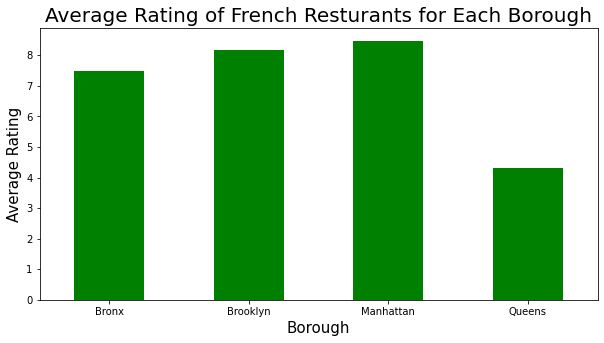

In [61]:
french_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average Rating of French Resturants for Each Borough', fontsize=20)

plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Visually map neighborhoods with an average rating greater than or equal to 8

In [48]:
ny_neighborhood_8 = ny_neighborhood_stats[ny_neighborhood_stats['Average Rating'] >= 8.0]
ny_neighborhood_8

,Neighborhood,Average Likes,Average Rating
2,Bushwick,98.000000,8.300000
3,Carnegie Hill,36.500000,8.100000
4,Carroll Gardens,115.500000,8.300000
5,Central Harlem,59.000000,8.350000
6,Chelsea,255.000000,8.400000
8,Civic Center,419.500000,8.550000
9,Clinton,179.000000,8.050000
10,Cobble Hill,203.000000,8.400000
12,East Harlem,80.000000,9.100000
13,Financial District,58.000000,8.600000


In [49]:
ny_neighborhood_8 = pd.merge(ny_neighborhood_8, ny_data, on='Neighborhood')
ny_neighborhood_8 = ny_neighborhood_8[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_8

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bushwick,40.698116,-73.925258,8.300000
1,Manhattan,Carnegie Hill,40.782683,-73.953256,8.100000
2,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.300000
3,Manhattan,Central Harlem,40.815976,-73.943211,8.350000
4,Manhattan,Chelsea,40.744035,-74.003116,8.400000
5,Staten Island,Chelsea,40.594726,-74.189560,8.400000
6,Manhattan,Civic Center,40.715229,-74.005415,8.550000
7,Manhattan,Clinton,40.759101,-73.996119,8.050000
8,Brooklyn,Cobble Hill,40.687920,-73.998561,8.400000
9,Manhattan,East Harlem,40.792249,-73.944182,9.100000


Create map to display

In [51]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the restaurant list
for lat, lng, in ny_neighborhood_8[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='green',
            fill=True,
            fill_color='white',
            fill_opacity=0.6
        )
    )

In [57]:
ny_neighborhood_8['Label']=ny_neighborhood_8['Neighborhood']+', '+ny_neighborhood_8['Borough']+'('+ny_neighborhood_8['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_8[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)    

# add incidents to map
ny_map.add_child(incidents)

In [56]:
ny_neighborhood_8.sort_values('Average Rating', ascending = False)

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
22,Manhattan,Soho,40.722184,-74.000657,9.200000,"Soho, Manhattan(9.2)"
9,Manhattan,East Harlem,40.792249,-73.944182,9.100000,"East Harlem, Manhattan(9.1)"
21,Brooklyn,North Side,40.714823,-73.958809,8.800000,"North Side, Brooklyn(8.8)"
17,Manhattan,Midtown,40.754691,-73.981669,8.800000,"Midtown, Manhattan(8.8)"
16,Manhattan,Lower East Side,40.717807,-73.980890,8.800000,"Lower East Side, Manhattan(8.8)"
20,Manhattan,Noho,40.723259,-73.988434,8.800000,"Noho, Manhattan(8.799999999999999)"
15,Manhattan,Little Italy,40.719324,-73.997305,8.750000,"Little Italy, Manhattan(8.75)"
13,Manhattan,Greenwich Village,40.726933,-73.999914,8.733333,"Greenwich Village, Manhattan(8.733333333333333)"
25,Manhattan,West Village,40.734434,-74.006180,8.666667,"West Village, Manhattan(8.666666666666668)"
10,Manhattan,Financial District,40.707107,-74.010665,8.600000,"Financial District, Manhattan(8.6)"


In [58]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

Visualize all NYC buroughs based on average Rating.

In [59]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')